# Testing Notebook 03

This notebook is where I'm developing the containment methods for multivariate functions in $\mathbb{R}^n$

In [91]:
import pandas as pd
import numpy as np
from statdepth.depth import banddepth, samplebanddepth

import plotly.express as px
import matplotlib.pyplot as plt

We now test the `Delaunay` object from `scipy`, which should allow us to analyze simplices formed by our datapoints.

In [92]:
from scipy.spatial import Delaunay

`o` is a convex hull and `c` is a convex hull formed by the same nodes but an addition node inside. I want to figure out how to detect the fact that this extra inner point doesn't change the simplex

In [93]:
p1 = np.array([[0,0], [1,1], [2,0]])
o = Delaunay(p1)

p2 = np.array([[0,0], [1,1], [2,0], [1, .5]])
c = Delaunay(p2)

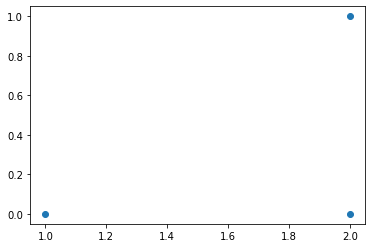

In [94]:
ohull = o.convex_hull
plt.scatter(x=[i[0] for i in ohull], y=[i[1] for i in ohull]);

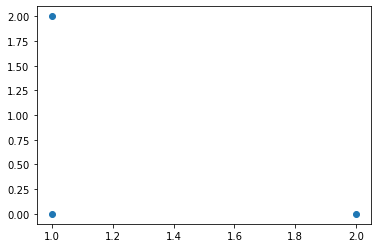

In [95]:
chull = c.convex_hull
plt.scatter(x=[i[0] for i in chull], y=[i[1] for i in chull]);

This is the Delaunay with no inner points

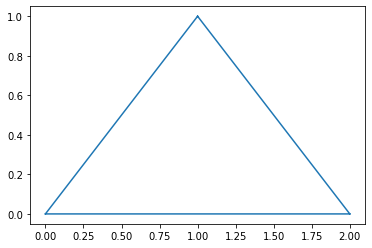

In [96]:
plt.triplot(p1[:,0], p1[:,1], o.simplices);

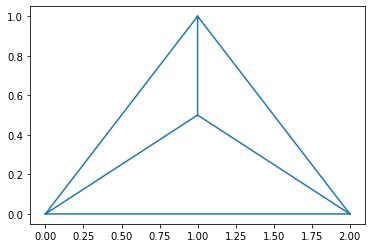

In [97]:
plt.triplot(p2[:,0], p2[:,1], c.simplices);

In [98]:
o.simplices

array([[2, 1, 0]], dtype=int32)

In [99]:
c.simplices

array([[2, 3, 0],
       [3, 1, 0],
       [1, 3, 2]], dtype=int32)

The Delaunay object doesn't work well, so we'll use `ConvexHull` instead

In [100]:
from scipy.spatial import ConvexHull

In [101]:
ohull = ConvexHull(p1)
chull = ConvexHull(p2)

In [102]:
ohull.vertices

array([0, 2, 1], dtype=int32)

In [103]:
all(chull.vertices == ohull.vertices)

True

In [104]:
df = pd.DataFrame([[0,0], [1,1], [2,0], [1, .5]])
df

,0,1
0,0,0.0
1,1,1.0
2,2,0.0
3,1,0.5


In [105]:
t = ConvexHull(df, incremental=True)
t.vertices

array([0, 2, 1], dtype=int32)

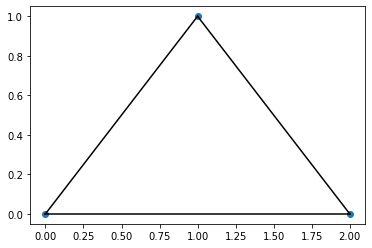

In [106]:
def plot_simplex(points, hull):
    plt.plot(points[:,0], points[:,1], 'o')
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1], 'k-')
        
plot_simplex(p1, t)

In [131]:
def convex_hull(data: list):
    try:
        simplex = ConvexHull(data)
    except FileNotFoundError as e:
        print(f'Error generating simplex, geometrical degeneracy. \n')
        print(e)

In [132]:
p1 = np.array([[0,0,1], [1,1,1], [2,0,1], [.1, .2,1]])
convex_hull(p1)

QhullError: QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 721830790  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  2  Error-roundoff 2.8e-15  _one-merge 1.9e-14
  _near-inside 9.7e-14  Visible-distance 5.5e-15  U-max-coplanar 5.5e-15
  Width-outside 1.1e-14  _wide-facet 3.3e-14  _maxoutside 2.2e-14

The input to qhull appears to be less than 3 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p3(v4):   0.1   0.2     1
- p1(v3):     1     1     1
- p2(v2):     2     0     1
- p0(v1):     0     0     1

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distances is 2.8e-15.  The center point, facets and distances
to the center point are as follows:

center point    0.775      0.3        1

facet p1 p2 p0 distance=    0
facet p3 p2 p0 distance=    0
facet p3 p1 p0 distance=    0
facet p3 p1 p2 distance=    0

These points either have a maximum or minimum x-coordinate, or
they maximize the determinant for k coordinates.  Trial points
are first selected from points that maximize a coordinate.

The min and max coordinates for each dimension are:
  0:         0         2  difference=    2
  1:         0         1  difference=    1
  2:         1         1  difference=    0

If the input should be full dimensional, you have several options that
may determine an initial simplex:
  - use 'QJ'  to joggle the input and make it full dimensional
  - use 'QbB' to scale the points to the unit cube
  - use 'QR0' to randomly rotate the input for different maximum points
  - use 'Qs'  to search all points for the initial simplex
  - use 'En'  to specify a maximum roundoff error less than 2.8e-15.
  - trace execution with 'T3' to see the determinant for each point.

If the input is lower dimensional:
  - use 'QJ' to joggle the input and make it full dimensional
  - use 'Qbk:0Bk:0' to delete coordinate k from the input.  You should
    pick the coordinate with the least range.  The hull will have the
    correct topology.
  - determine the flat containing the points, rotate the points
    into a coordinate plane, and delete the other coordinates.
  - add one or more points to make the input full dimensional.


In [117]:
containment = 'asdf'

if isinstance(containment, str):
    raise ValueError(f'containment argument \'{containment}\' is invalid. Use one of [\'r2\', \'r2_enum\', \'simplex \'] or a pass a custom containment function.')

ValueError: containment argument 'asdf' is invalid. Use one of ['r2', 'r2_enum', 'simplex '] or a pass a custom containment function.

In [114]:
def is_in_simplex(simplex_points, point) -> bool:
    # Generate convex hull and grab its vertices
    hull = ConvexHull(df, incremental=True)
    vertices = hull.vertices
    
    # Generate the convex hull with new point
    hull.add_points([point])
    
    # Check if they are the same
    # If they are, then the added point must be contained in the original hull
    if len(vertices) != len(hull.vertices):
        return False
    
    return all(vertices == hull.vertices)

is_in_simplex(df, pd.Series([1, .5]))

True